In [23]:
%pip install numpy matplotlib scipy sympy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:

# Simulador de Filtros
# Autores: Ramiro Belsito y Ignacio Sammartino
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import TransferFunction, ZerosPolesGain, zpk2tf, freqresp
import sympy as sp
from numpy.polynomial.legendre import Legendre
from numpy.polynomial import Polynomial

import math
import sys

In [26]:


def ENG( valor: float, unidad: str) -> str:
    """
    Convierte un valor de resistencia o capacitancia a notación de ingeniería.
    
    Parámetros:
    - valor: El valor numérico (float)
    - unidad: 'Ohm' para resistencias o 'F' para capacitores

    Retorna:
    - str con el valor en notación de ingeniería (ej. 4.7 kOhm, 10 nF)
    """
    prefijos = {
        -12: 'p',
        -9: 'n',
        -6: 'µ',
        -3: 'm',
         0: '',
         3: 'k',
         6: 'M',
         9: 'G',
    }

    if valor == 0:
        return f"0 {unidad}"
    
    exponente = int(math.floor(math.log10(abs(valor)) // 3 * 3))
    exponente = max(min(exponente, 9), -12)  # limitar a prefijos comunes
    valor_normalizado = valor / (10 ** exponente)
    
    prefijo = prefijos.get(exponente, f"e{exponente}")
    
    return f"{valor_normalizado:.3g} {prefijo}{unidad}"

def ingresar_valor(value : str) -> float:
    try: 
        return float(value)
    except ValueError:
        if (re.search(r"(\d+(\.\d+)?)([kMG]?)", value)):
            match = re.search(r"(\d+(\.\d+)?)([kMG]?)", value)
            if match:
                num = float(match.group(1))
                if match.group(3) == 'k':
                    return num * 1e3
                elif match.group(3) == 'M':
                    return num * 1e6
                elif match.group(3) == 'G':
                    return num * 1e9
        else:
            print("Error: Unidad no válida")
            check = False
            exit(1)

def poly_compose_with_rational(p, Nf, Df):
    """
    Compose polynomial p(x) with rational function Nf(s)/Df(s).
    p: coefficients of polynomial in x (descending powers)
    Nf, Df: coefficients of numerator and denominator of f(s) (descending powers)
    Returns: numerator and denominator of composed transfer function as arrays
    """
    deg = len(p) - 1
    numerator = np.poly1d([0])  # start with zero polynomial

    Nf_poly = np.poly1d(Nf)
    Df_poly = np.poly1d(Df)

    for k, coeff in enumerate(p):
        power = deg - k
        Nf_pow = Nf_poly**power if power > 0 else np.poly1d([1])
        Df_pow = Df_poly**(deg - power) if (deg - power) > 0 else np.poly1d([1])

        # term is a poly1d
        term = np.poly1d([coeff]) * Nf_pow * Df_pow

        numerator = numerator + term  # poly1d + poly1d is safe

    denominator = Df_poly**deg

    return numerator.coeffs, denominator.coeffs


def compose_transfer_functions(H, f):
    """
    Compose H(f(s)) where H and f are TransferFunction objects.
    """
    Nh, Dh = H.num, H.den
    Nf, Df = f.num, f.den

    # Compose numerator of H with f(s)
    num_comp, den_comp = poly_compose_with_rational(Nh, Nf, Df)
    # Compose denominator of H with f(s)
    num_comp_den, den_comp_den = poly_compose_with_rational(Dh, Nf, Df)

    # The composed transfer function numerator and denominator
    numerator = np.polymul(num_comp, den_comp_den)
    denominator = np.polymul(den_comp, num_comp_den)

    # Return new transfer function
    return TransferFunction(numerator, denominator)

# Ejemplo de uso de las funciones: Creas las f(s) = TransferFunction([1,2][1,3]) que resulta en
# f(s) = (s + 2)/(s + 3) y despues usas H_composed = comopose_transfer_functions(H, f) 

def get_zeros_and_poles(F):
    """
    Función que calcula los ceros y los polos de una función transferencia
    
    :param F: función transferencia como expresión de sympy

    :returns: ceros y polos de la función transferencias
    """

    #Obtenemos  el numerador y denominador de la expresión
    num = sp.fraction(F)[0]
    den = sp.fraction(F)[1]
    

    #Obtenemos los coeficientes del numerador y denominador. Los ifs son para los casos donde el numerador o denominador son de orden 1. 

    
    #Si no tiene ceros
    if num.is_number:
        num_coeffs = num
    #Si tiene ceros
    else:
        num_coeffs = sp.Poly(num).all_coeffs()

    #Si no tiene polos

    if den.is_number:
    
        den_coeffs = den
    #Si tiene polos
    else:
        den_coeffs = sp.Poly(den).all_coeffs()


    #Para mejor manejo vamos a pasar estos coeficientes a un tipo de arreglo de numpy (confíen)
    num_coeffs = np.array(num_coeffs, dtype = float)
    den_coeffs = np.array(den_coeffs, dtype = float)

    

    #Obtenemos las raíces de esos polinomios. 
    #Esto lo vamos a hacer a través de scipy, que tiene una función que a partir de los coeficientes del numerador y denominador, te da los polos y ceros
    
    pz = signal.tf2zpk(num_coeffs,den_coeffs)

    #pz es una arreglo [ceros, polos, ganancia]

    zeros = pz[0]
    poles = pz[1]

    return zeros, poles

def plot_pz_map(zeros, poles):
    """
    Función que grafica el PZ map diagrama de polos y ceros. 
        
    :param zeros: lista de ceros
    :param poles: lista de polos

    """
    plt.figure(figsize=(8, 6))
    zeros_parte_real = np.real(zeros)
    zeros_parte_imaginaria =  np.imag(zeros)
    plt.scatter(zeros_parte_real,zeros_parte_imaginaria, marker='o', color='b')

    poles_parte_real = np.real(poles)
    poles_parte_imaginaria =  np.imag(poles)
    plt.scatter(poles_parte_real,poles_parte_imaginaria, marker='x', color='b')

    #Pueden cambiar este límite como quieram
    plt.xlim([-1.6, 1.6])

    plt.xlabel('$\\sigma$')
    plt.ylabel('$j\\omega$')

    plt.grid()
    plt.show()

def plot_bode(mag, w):
    """"
    Función que plotea el módulo de la respuesta en frecuencia de un sistema.

    :param mag: valores de magnitud
    :param w: valores de frecuencia

    """
    
    fig, ax = plt.subplots(figsize=(7, 5))

    #Estos valores los pueden cambiar
    Gp = 0.8
    Ga = 0.0316
    wa = 1.5 
    wp = 1


    ax.plot(w, mag)
    ax.add_patch(plt.Rectangle((0,1),wp,-(1-Gp),facecolor='green',alpha=0.2))
    ax.add_patch(plt.Rectangle((wa,0),1,Ga,facecolor='red',alpha=0.2))
    plt.xlim([0, 2])
    plt.ylim([0, 1.05])
    plt.ylabel('Módulo [v/v]')
    plt.xlabel('$\\omega$  [rad/s]')
    plt.grid()
    plt.title('Módulo de la respuesta en frecuencia')
    plt.show()

    
class Filtro:
    TipoDeFiltro = ""
    wpmin = 0
    wpmax = 0
    wamin = 0
    wamax = 0
    wp = 0
    wa = 0
    w0 = 0
    Ap = 0
    Aa = 0
    waN = 0
    wpN = 0
    B = 0
    BA = 0
    funcionDeAprox = ""
    def obtener_filtro(self):
        self.TipoDeFiltro = input("Ingrese el tipo de filtro (PasaBajo, Pasself.Aalto, PasaBanda, RechazaBanda): ")

        if re.search("alto", self.TipoDeFiltro, re.IGNORECASE) or re.search("hp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "HP"
        elif re.search("bajo", self.TipoDeFiltro, re.IGNORECASE) or re.search("lp", self.TipoDeFiltro, re.IGNORECASE):
            self.TipoDeFiltro = "LP"
        else:
            if re.search("rechaza", self.TipoDeFiltro, re.IGNORECASE) or re.search("br", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BR"
            elif re.search("banda", self.TipoDeFiltro, re.IGNORECASE) or re.search("bp", self.TipoDeFiltro, re.IGNORECASE):
                self.TipoDeFiltro = "BP"
            else:
                print("Error: Tipo de filtro no reconocido.")
                exit(1)

        check = True

        if self.TipoDeFiltro == "LP":
            self.wp = np.pi*2*ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.wa = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.waN = self.wa/self.wp
            self.wpN = 1
            if not ((self.wp < self.wa) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wp = ", ENG(self.wp, "(rad/s)"))
                print("wa = ", ENG(self.wa, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
                
        elif self.TipoDeFiltro == "HP":
            self.wp = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso (Hz): "))
            self.wa = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo (Hz): "))
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.waN = self.wp/self.wa
            self.wpN = 1
            if not ((self.wa < self.wp) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wp = ", ENG(self.wp, "(rad/s)"))
                print("wa = ", ENG(self.wa, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BP":
            self.wamin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de rechazo inferior (Hz): "))
            self.wpmin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.w0 = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.wpmax = self.w0**2 / self.wpmin
            self.wamax = self.w0**2 / self.wamin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.B = self.wpmax - self.wpmin
            self.BA = self.wamax - self.wamin
            self.waN = self.BA/self.B
            self.wpN = 1
            if not ((self.wamin < self.wpmin < self.w0 < self.wpmax < self.wamax) and (self.Ap < self.Aa)):
                print("Error: Los parametros no cumplen con la condición de diseño.")
                check = False
            else:
                print("wamin = ", ENG(self.wamin, "(rad/s)"))
                print("wpmin = ", ENG(self.wpmin, "(rad/s)"))
                print("w0 = ", ENG(self.w0, "(rad/s)"))
                print("wpmax = ", ENG(self.wpmax, "(rad/s)"))
                print("wamax = ", ENG(self.wamax, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")
        elif self.TipoDeFiltro == "BR":
            self.wpmin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de paso inferior (Hz): "))
            self.wamin = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia de atenuacion inferior (Hz): "))
            self.w0 = 2*np.pi*ingresar_valor(input("Ingrese la frecuencia central (Hz): "))
            self.wpmax = self.w0**2 / self.wpmin
            self.wamax = self.w0**2 / self.wamin
            self.Ap = float(input("Ingrese la atenuación en banda de paso (dB): "))
            self.Aa = float(input("Ingrese la atenuación en banda de rechazo (dB): "))
            self.B = self.wpmax - self.wpmin
            self.BA = self.wamax - self.wamin
            self.waN = self.B/self.BA
            self.wpN = 1
            if not ((self.wpmin < self.wamin < self.w0 < self.wamax < self.wpmax) and (self.Ap < self.Aa)):
                print("Error: Las frecuencias no cumplen con la condición de diseño.")
                check = False
            else:
                print("wpmin = ", ENG(self.wpmin, "(rad/s)"))
                print("wamin = ", ENG(self.wamin, "(rad/s)"))
                print("w0 = ", ENG(self.w0, "(rad/s)"))
                print("wamax = ", ENG(self.wpmax, "(rad/s)"))
                print("wpmax = ", ENG(self.wamax, "(rad/s)"))
                print("Ap = ", self.Ap, "dB")
                print("Aa = ", self.Aa, "dB")
                print("Las frecuencias cumplen con la condición de diseño.")

        print("waN = ", ENG(self.waN, "(rad/s)"))
        print("wpN = ", ENG(self.wpN, "(rad/s)"))
        self.Ap = -self.Ap
        self.Aa = -self.Aa

        if not check:
            sys.exit(1)
        return
    def obtenerFuncAprox(self):
        self.funcionDeAprox = input("Ingrese la función de aproximación (Butterworth, Chebyshev I, Chebyshev Inverso, Optimo L): ")
        if re.search(r'butter(?:worth)?', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Butter"
        elif re.search(r'\bche[bv](?:y|i|í|yshev|yschev|yshef)?\s*(?:i|1)\b(?!\s*\w)', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Cheby I"
        elif re.search(r'\bche[bv](?:y|i|í|vi|yshev|yschev|yshef)?\s*(?:ii|2)\b(?!\s*\w)|\bche[bv](?:y|i|í|yshev|yschev|yshef)?\s*inverso\b(?!\s*\w)', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Cheby II"
        elif re.search(r'\b(?:legendre(?:\s+papulis)?|papulis(?:\s+legendre)?|ó?ptimo\s*L)\b(?!\s*\w)', self.funcionDeAprox, re.IGNORECASE):
            self.funcionDeAprox = "Optimo L"
        else:
            print("Error: Función de aproximación no reconocida.")
            exit(1)
    def plotPlantillaNormalizada(self, H):
        AaLineal = (10**(self.Aa/20))
        ApLineal = (10**(self.Ap/20))
        xlim = self.waN * 2
        ylim = 1.1
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.add_patch(plt.Rectangle((0, 0), self.wpN, ApLineal, color='red', alpha=0.3))
        ax.add_patch(plt.Rectangle((self.waN, AaLineal), xlim, ylim, color='red', alpha=0.3))
        ax.plot([0, self.wpN], [ApLineal, ApLineal], 'r--', label=f'Gp = {ApLineal:.4f} veces')
        ax.plot([self.wpN, self.wpN], [0, ApLineal], 'r--', label=f'wpN = {ENG(self.wpN, "(rad/s)")}')
        ax.plot([self.waN, self.waN], [AaLineal, ylim], 'r--', label=f'waN = {ENG(self.waN, "(rad/s)")}')
        ax.plot([self.waN, xlim], [AaLineal,AaLineal], 'r--', label=f'Ga = {AaLineal:.4f} veces')
        
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        w_axis = np.linspace(0, xlim, 1000)
        w_axis, mag, phase = signal.bode(H, w_axis)
        mag_en_veces = 10**(mag/20)
        ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
        plt.title(f"Plantilla LP Normalizada del filtro {self.TipoDeFiltro}")
        plt.xlabel("Frecuencia Normalizada (rad/s)")
        plt.ylabel("Ganancia (Veces)")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()  
        return
    def plotPlantillaArbitraria(self, H):
        match self.TipoDeFiltro:
            case "LP":
                AaLineal = (10**(self.Aa/20))
                ApLineal = (10**(self.Ap/20))
                xlim = self.wa * 2
                ylim = 1.1
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.add_patch(plt.Rectangle((0, 0), self.wp, ApLineal, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wa, AaLineal), xlim, ylim, color='red', alpha=0.3))
                ax.plot([0, self.wp], [ApLineal, ApLineal], 'r--', label=f'Gp = {ApLineal:.4f} veces')
                ax.plot([self.wp, self.wp], [0, ApLineal], 'r--', label=f'wp = {ENG(self.wp, "(rad/s)")}')
                ax.plot([self.wa, self.wa], [AaLineal, ylim], 'r--', label=f'wa = {ENG(self.wa, "(rad/s)")}')
                ax.plot([self.wa, xlim], [AaLineal,AaLineal], 'r--', label=f'Ga = {AaLineal:.4f} veces')
                plt.xlim([0, xlim])
                plt.ylim([0, ylim])
                # Desnormalizacion LPN - LP
                H_tf = H.to_tf()
                f = TransferFunction([1, 0], [self.wp]) 
                H_composed = compose_transfer_functions(H_tf, f)
                w_axis = np.linspace(0, xlim, 1000)
                w_axis, mag, _ = signal.bode(H_composed, w_axis)
                mag_en_veces = 10**(mag/20)
                ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Ganancia (Veces)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show() 
            case "HP":
                AaLineal = (10**(self.Aa/20))
                ApLineal = (10**(self.Ap/20))
                xlim = self.wp * 2
                ylim = 1.1
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.add_patch(plt.Rectangle((0, AaLineal), self.wa, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wp, 0), xlim - self.wp, ApLineal, color='red', alpha=0.3))
                ax.plot([self.wp, xlim], [ApLineal, ApLineal], 'r--', label=f'Ap = {ApLineal:.4f} veces')
                ax.plot([self.wp,self.wp], [0, ApLineal], 'r--', label=f'wp = {ENG(self.wp, "")} (rad/s)')
                ax.plot([self.wa,self.wa], [AaLineal, ylim], 'r--', label=f'wa = {ENG(self.wa,"")} (rad/s)')
                ax.plot([0, self.wa], [AaLineal,AaLineal], 'r--', label=f'Aa = {AaLineal:.4f} veces')
                ax.set_xlim(0, xlim)
                ax.set_ylim(0, ylim)
                # Desnormalizacion LPN - HP
                H_tf = H.to_tf()
                f = TransferFunction([self.wp], [1, 0])
                H_composed = compose_transfer_functions(H_tf, f)
                w_axis = np.linspace(0, xlim, 1000)
                w_axis, mag, _ = signal.bode(H_composed, w_axis)
                mag_en_veces = 10**(mag/20)
                ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
            case "BP":
                AaLineal = (10**(self.Aa/20))
                ApLineal = (10**(self.Ap/20))
                xlim = self.wamax * 2
                ylim = 1.1
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.add_patch(plt.Rectangle((0,AaLineal), self.wamin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wpmin, 0), self.wpmax - self.wpmin, ApLineal, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wamax, AaLineal), xlim, ylim, color='red', alpha=0.3))
                ax.plot([self.wpmin, self.wpmax], [ApLineal, ApLineal], 'r--', label=f'Ap = {ApLineal:.4f} veces')
                ax.plot([0,self.wamin], [AaLineal, AaLineal], 'r--', label=f'Aa = {AaLineal:.4f} veces')
                ax.plot([self.wamax, xlim], [AaLineal, AaLineal], 'r--')
                ax.plot([self.wamin, self.wamin], [AaLineal, ylim], 'r--', label=f'wa- = {ENG(self.wamin,"")} (rad/s)')
                ax.plot([self.wpmin, self.wpmin], [0, ApLineal], 'r--', label=f'wp- = {ENG(self.wpmin,"")} (rad/s)')
                ax.plot([self.wpmax, self.wpmax], [0, ApLineal], 'r--', label=f'wp+ = {ENG(self.wpmax,"")} (rad/s)')
                ax.plot([self.wamax, self.wamax], [AaLineal,ylim], 'r--', label=f'wa+ = {ENG(self.wamax,"")} (rad/s)')

                ax.plot([self.w0, self.w0], [0, ylim], 'b--', label=f'w0 = {ENG(self.w0,"")} (rad/s)')
                ax.set_xlim(0, xlim)
                ax.set_ylim(0, ylim)

                # Desnormalizacion LPN - BP
                H_tf = H.to_tf()
                f = TransferFunction([1,0,self.w0**2], [self.B, 0])
                H_composed = compose_transfer_functions(H_tf, f)
                # Grafico de H
                w_axis = np.linspace(0, xlim, 1000)
                w_axis, mag, _ = signal.bode(H_composed, w_axis)
                mag_en_veces = 10**(mag/20)
                ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
            case "BR":
                AaLineal = (10**(self.Aa/20))
                ApLineal = (10**(self.Ap/20))
                xlim = self.wpmax * 2
                ylim = 1.1
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.add_patch(plt.Rectangle((0,0), self.wpmin, ApLineal, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wamin,AaLineal), self.wamax - self.wamin, ylim, color='red', alpha=0.3))
                ax.add_patch(plt.Rectangle((self.wpmax,0), xlim, ApLineal, color='red', alpha=0.3))
                ax.plot([0, self.wpmin], [ApLineal, ApLineal], 'r--', label=f'Ap = {ApLineal:.4f} veces')
                ax.plot([self.wamin, self.wamax], [AaLineal, AaLineal], 'r--', label=f'Aa = {AaLineal:.4f} veces')
                ax.plot([self.wpmax, xlim], [ApLineal,ApLineal], 'r--')
                ax.plot([self.wpmin, self.wpmin], [0,ApLineal], 'r--', label=f'wp- = {ENG(self.wpmin,"")} (rad/s)')
                ax.plot([self.wamin, self.wamin], [AaLineal, ylim], 'r--', label=f'wa- = {ENG(self.wamin, "")} (rad/s)')
                ax.plot([self.wamax, self.wamax], [AaLineal,ylim], 'r--', label=f'wa+ = {ENG(self.wamax, "")} (rad/s)')
                ax.plot([self.wpmax, self.wpmax], [0, ApLineal], 'r--', label=f'wp+ = {ENG(self.wpmax, "")} (rad/s)')

                ax.plot([self.w0, self.w0], [0, ylim], 'b--', label=f'w0 = {ENG(self.w0, "")} (rad/s)')
                
                ax.set_xlim(0, xlim)
                ax.set_ylim(0, ylim)

                # Desnormalizacion LPN - BR
                H_tf = H.to_tf()
                f = TransferFunction([self.B, 0], [1,0,self.w0**2])
                H_composed = compose_transfer_functions(H_tf, f)
                w_axis = np.linspace(0, xlim, 1000)
                w_axis, mag, _ = signal.bode(H_composed, w_axis)
                mag_en_veces = 10**(mag/20)
                # Grafico de H
                ax.plot(w_axis, mag_en_veces, 'b-', label='Respuesta en frecuencia')
                plt.title(f"Plantilla de {self.TipoDeFiltro}")
                plt.xlabel("Frecuencia (rad/s)")
                plt.ylabel("Atenuación (dB)")
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.legend()
                plt.show()
    

filtro = Filtro()
filtro.obtener_filtro()


wamin =  4.57 k(rad/s)
wpmin =  13.6 k(rad/s)
w0 =  15.1 k(rad/s)
wpmax =  16.8 k(rad/s)
wamax =  49.8 k(rad/s)
Ap =  1.0 dB
Aa =  40.0 dB
Las frecuencias cumplen con la condición de diseño.
waN =  14.2 (rad/s)
wpN =  1 (rad/s)


In [27]:

from sympy import Poly

def get_chebyshev_poly (n, show = False):
    """ 
    Función que devuelve el polinomio de chebyshev de orden n

    :param n: orden

    :returns el polinomio como expresión de sympy
    """
    x = sp.symbols('x')

    C = [0] *(n + 1)  #Genera una lista todas con ceros de tamaño orden + 1

    #Polinomios iniciales de orden 0 y 1
    C[0] = 1
    C[1] = x

    #Forma recursiva
    
    for z in range (2,len(C)):
        C[z] = 2*x*C[z-1] - C[z-2]
        if show:
            display(f'Orden {z}: ')
            display(C[z])

    return C[n], x

def funcionDeAproximacionButter(filtro: Filtro):
    # Hallar xi
    ApLineal = 10**(filtro.Ap/20)
    AaLineal = 10**(filtro.Aa/20)
    xi = sp.symbols('xi')
    xi = sp.solve(1/(1+xi**2) - ApLineal**2, xi)
    xi = xi[1] # xi es el valor positivo
    # Hallar n
    n = sp.symbols('n')
    func = (1/(1+(xi**2)*((filtro.waN)**(2*n))))- AaLineal**2
    n = sp.solve(func, n)
    nCalc = math.ceil(abs(n[0]))
    print("n = ", nCalc)
    # Hallar w0
    w = sp.symbols('w')
    G2 = (1/(1+(xi**2)*((w)**(2*nCalc))))
    display(G2)
    # evaluar en w = s/j 
    s = sp.symbols('s')
    G2 = G2.subs(w, s/sp.I)
    display(G2)
    zeros, poles = get_zeros_and_poles(G2)
    polesImplementables = []
    for p in poles:
        if sp.re(p) <= 0:
            polesImplementables.append(p)
    print("Ceros: ", zeros)
    print("Polos: ", polesImplementables)
    gain = np.cumprod(polesImplementables)[-1]*(1)
    H = signal.ZerosPolesGain(zeros, polesImplementables, gain)
    plot_pz_map(zeros, polesImplementables)
    return H

def funcionDeAproximacionChebyshev1(filtro: Filtro):
    ApLineal = 10**(filtro.Ap/20)
    AaLineal = 10**(filtro.Aa/20)
    x = sp.symbols('x')
    s = sp.symbols('s')
    w = sp.symbols('w')
    xi = sp.symbols('xi')
    p = sp.symbols('p') # Polinomio de chebyshev
    G = 1/(1+(xi*p)**2)
    display(G)
    G_xi = G.subs(p, 1)
    eq_xi = sp.Eq(G_xi, ApLineal**2)
    sol_xi = sp.solve(eq_xi)
    sol_xi = sol_xi[1] # xi es el valor positivo
    G_xi = G.subs(xi, sol_xi)
    display(G_xi)
    # Hallar n
    CumplePlantilla = False
    i = 0
    while (not CumplePlantilla):
        print(f"\rProbando orden: {i}", end='', flush=True)
        G_xi = G.subs(xi, sol_xi)
        if i == 0:
            cheby = 1
        elif i == 1:
            cheby = w
        else:
            cheby, x = get_chebyshev_poly(i, show=False)
            cheby = cheby.subs(x,w)
        G_xi = G_xi.subs(p, cheby)
        G_n = G_xi.subs(w, filtro.waN)
        if (G_n < AaLineal**2):
            CumplePlantilla = True
            n = i
        else:
            i += 1
    print("\n")
    print("Orden: ", n)
    print("G_n: ", G_n)
    Gs = G_xi.subs(w, s/sp.I) #sp.I es el número imaginario
    display(Gs)
    zeros, poles = get_zeros_and_poles(Gs)
    polesImplementables = []
    for p in poles:
        if sp.re(p) <= 0:
            polesImplementables.append(p)
    print("Ceros: ")
    if len(zeros) == 0:
        print("  Sin ceros")
    else:
        for z in zeros:
            print(f"  {z.real:.4f} {'+' if z.imag >= 0 else '-'} {abs(z.imag):.4f}j")
        
    print("Polos: ")
    for p in polesImplementables:
        print(f"  {p.real:.4f} {'+' if p.imag >= 0 else '-'} {abs(p.imag):.4f}j")   
    plot_pz_map(zeros, polesImplementables)
    if n%2:
        gain = np.cumprod(polesImplementables)[-1]*(1)  #Magic number?? Cómo es que a veces va Gp y otras no...
    else:
        gain = np.cumprod(polesImplementables)[-1]*(ApLineal) #Magic number?? Cómo es que a veces va Gp y otras no...
    H = signal.ZerosPolesGain(zeros, polesImplementables, gain)

    return H

    # Generador automático de polinomios de Chebyshev tipo II


def funcionDeAproximacionChebyshev2(filtro: Filtro):
    N, wc = signal.cheb2ord(filtro.wpN, filtro.waN, -1*filtro.Ap, -1*filtro.Aa, analog=True)
    print("Orden: ", N)
    zeros, poles, k = signal.cheby2(N, -1*filtro.Aa, wc, analog=True, output='zpk') 
    H = signal.ZerosPolesGain(zeros, poles, k)
    print("Ceros: ")
    if len(zeros) == 0:
        print("  Sin ceros")
    else:
        for z in zeros:
            print(f"  {z.real:.4f} {'+' if z.imag >= 0 else '-'} {abs(z.imag):.4f}j")
        
    print("Polos: ")
    for p in poles:
        print(f"  {p.real:.4f} {'+' if p.imag >= 0 else '-'} {abs(p.imag):.4f}j")   
    plot_pz_map(zeros, poles)
    return H

def get_Leps(n, eps):
    k = int(n / 2 - 1) if (n % 2 == 0) else int((n - 1) / 2)
        
    a = []
    for i in range(k + 1):
        if n % 2 == 0:
            if k % 2 == 0:
                if i == 0:
                    a.append(1 / (np.sqrt(((k + 1) * (k + 2)))))
                elif i % 2 == 0:
                    a.append((2 * i + 1) * a[0])
                else:
                    a.append(0)
            else:
                if i == 1:
                    a.append(3 / (np.sqrt((k + 1) * (k + 2))))
                elif i % 2 == 0:
                    a.append(0)
                else:
                    a.append((2 * i + 1) * a[1] / 3)
        else:
            if i == 0:
                a.append(1 / (np.sqrt(2) * (k + 1)))
            else:
                a.append((2 * i + 1) * a[0])
    
    sum_prod_pol = Legendre(a).convert(kind=Polynomial)
    sum_prod_pol **= 2
    if n % 2 == 0:
        sum_prod_pol *= Polynomial([1, 1]) #multiplico por 1+x
    
    sum_prod_pol = sum_prod_pol.integ() # primitiva
    sum_prod_pol = sum_prod_pol(Polynomial([-1, 0, 2])) - sum_prod_pol(-1) # evalúo
    return Polynomial([1]) + sum_prod_pol*eps*eps

def select_roots(p):
    roots = p.roots()*(-1j) #vuelvo desde w al dominio de s
    valid_roots = []
    for root in roots:
        if root.real <= 0:
            valid_roots.append(root)
    return valid_roots

def funcionDeAproximacionOptimoL(filtro: Filtro):
    xi, p, w, s = sp.symbols('xi p w s')
    print( "Aa = ", filtro.Aa, "dB")
    print( "Ap = ", filtro.Ap, "dB")
    ApLineal2 = 10**(filtro.Ap/10)
    AaLineal2 = 10**(filtro.Aa/10)
    print("ApLineal2: ", ApLineal2)
    print("AaLineal2: ", AaLineal2)
    G2w = 1/(1+(xi*p)**2)
    G2w_xi = G2w.subs(p, 1)
    eq_xi = sp.Eq(G2w_xi, ApLineal2)
    sol_xi = sp.solve(eq_xi)
    sols = [s.evalf() for s in sp.solve(eq_xi, xi) if sp.im(s) == 0 and s > 0]
    if not sols:
        raise ValueError("No se encontró solución válida para xi")
    sol_xi = sols[0]
    nmin = 1
    nmax = 99
    n = nmin
    wan  = filtro.waN

    while True:
        L_eps = get_Leps(n, sol_xi)
        z = []
        p = select_roots(L_eps)
        p0 = np.prod(p) * (1 if n % 2 == 0 else -1) #en N tengo N polos y yo quiero obtener el producto de los polos negados para normalizar
        tf2 = ZerosPolesGain(z, p, p0)
        w = np.array([wan])
        _, H = signal.freqresp(tf2, w)
        tf2_wmax = abs(H[0])
        # print(self.N, tf2_wmin >= self.gp, tf2_wmax <= self.ga, tf2_wmin, tf2_wmax)
        if(n == nmax or tf2_wmax <= AaLineal2):
            H = ZerosPolesGain(z, p, p0)
            break
        n += 1
    print("Orden: ", n)
    print("Ceros: ")
    if len(z) == 0:
        print("  Sin ceros")
    else:
        for zi in z:
            print(f"  {zi.real:.4f} {'+' if zi.imag >= 0 else '-'} {abs(zi.imag):.4f}j")
    print("Polos: ")
    for pi in p:
        print(f"  {pi.real:.4f} {'+' if pi.imag >= 0 else '-'} {abs(pi.imag):.4f}j")
    plot_pz_map(z, p)
    
    return H



In [28]:
def select_roots(p):
    # Convierte los coeficientes a float para evitar problemas de tipo
    coefs = np.array(p.coef, dtype=float)
    poly = Polynomial(coefs)
    roots = poly.roots() * (-1j)
    valid_roots = []
    for root in roots:
        if root.real <= 0:
            valid_roots.append(root)
    return valid_roots

Función de aproximación: Optimo L
Aa =  -40.0 dB
Ap =  -1.0 dB
ApLineal2:  0.7943282347242815
AaLineal2:  0.0001
Orden:  4
Ceros: 
  Sin ceros
Polos: 
  -0.2949 + 1.0441j
  -0.7135 + 0.4155j
  -0.7135 - 0.4155j
  -0.2949 - 1.0441j


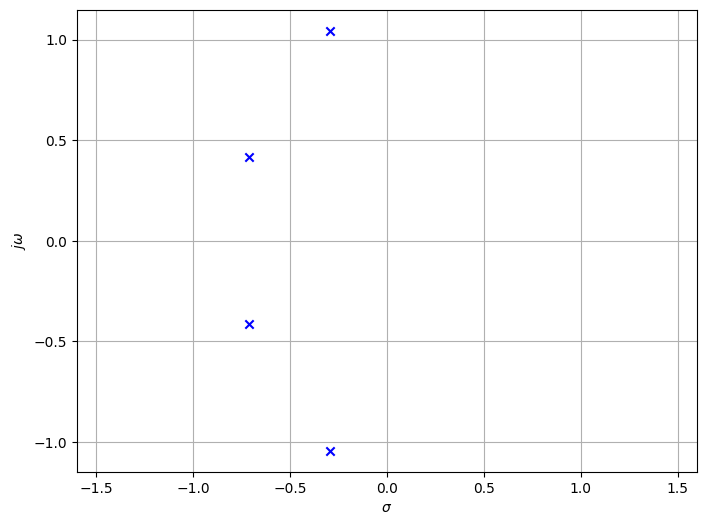

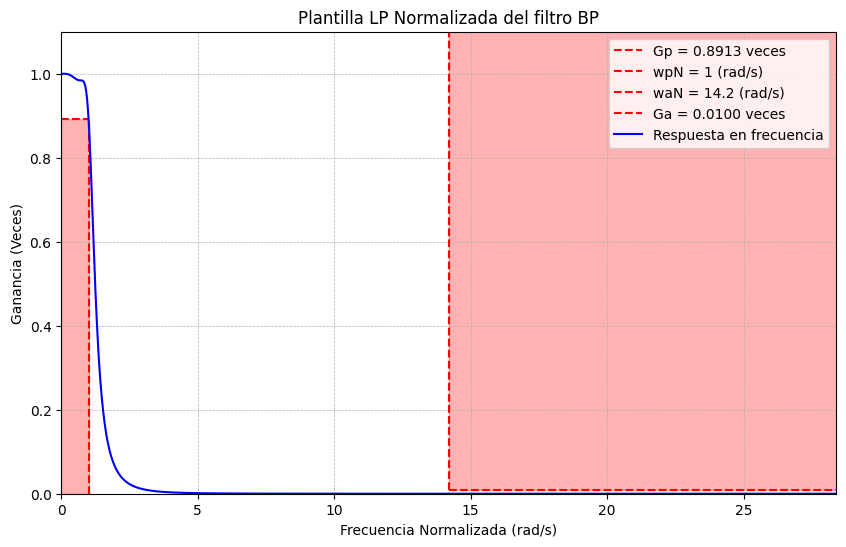

/usr/local/lib/python3.12/site-packages/scipy/signal/_ltisys.py:2202: RuntimeWarning: divide by zero encountered in log10
  mag = 20.0 * np.log10(abs(y))


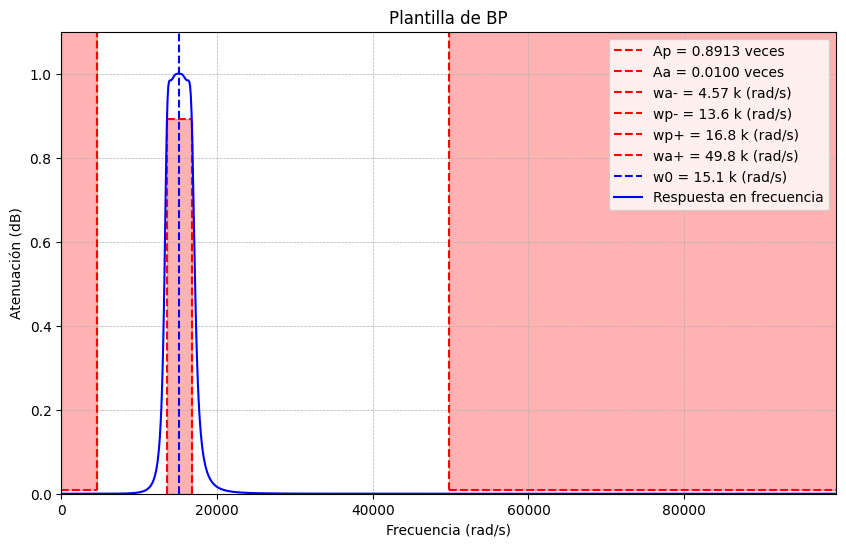

In [29]:
filtro.obtenerFuncAprox()
print(f"Función de aproximación: {filtro.funcionDeAprox}")
if filtro.funcionDeAprox == "Butter":
    H = funcionDeAproximacionButter(filtro)
elif filtro.funcionDeAprox == "Cheby I":
    H = funcionDeAproximacionChebyshev1(filtro)
elif filtro.funcionDeAprox == "Cheby II":
    H = funcionDeAproximacionChebyshev2(filtro)
elif filtro.funcionDeAprox == "Optimo L":
    H = funcionDeAproximacionOptimoL(filtro)

filtro.plotPlantillaNormalizada(H)
filtro.plotPlantillaArbitraria(H)

